In [1]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import os

# data augmantation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'path of data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Pretrained model (ResNet18)
model = models.resnet18(pretrained=True)

# Modify the last layer to custom data ( number of class)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# GPU is availabel or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#  (optimizer) and (loss function)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# دالة للتدريب والتقييم
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # for each train and valdation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # retrive data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

# train model
model = train_model(model, criterion, optimizer, num_epochs=10)

# test model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct / total:.2f}%')


C:\Users\fujtsu\anaconda3\envs\pythonProject1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fujtsu\anaconda3\envs\pythonProject1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 0.4261 Acc: 0.7888
val Loss: 0.3273 Acc: 0.8478
Epoch 1/9
----------
train Loss: 0.3462 Acc: 0.8320
val Loss: 0.2945 Acc: 0.8584
Epoch 2/9
----------
train Loss: 0.3047 Acc: 0.8627
val Loss: 0.3013 Acc: 0.8554
Epoch 3/9
----------
train Loss: 0.2962 Acc: 0.8646
val Loss: 0.3040 Acc: 0.8615
Epoch 4/9
----------
train Loss: 0.2556 Acc: 0.8828
val Loss: 0.3430 Acc: 0.8493
Epoch 5/9
----------
train Loss: 0.2494 Acc: 0.8866
val Loss: 0.2520 Acc: 0.8843
Epoch 6/9
----------
train Loss: 0.2334 Acc: 0.8946
val Loss: 0.2670 Acc: 0.8721
Epoch 7/9
----------
train Loss: 0.2400 Acc: 0.8919
val Loss: 0.2634 Acc: 0.8782
Epoch 8/9
----------
train Loss: 0.2045 Acc: 0.9132
val Loss: 0.2537 Acc: 0.8706
Epoch 9/9
----------
train Loss: 0.2179 Acc: 0.9082
val Loss: 0.3031 Acc: 0.8676
Best val Acc: 0.884323
Accuracy of the network on the validation images: 88.43%


In [2]:
# حفظ النموذج المدرب
torch.save(model.state_dict(), r'path_to_save\Pytorch_trained_model1.pth')

C:\Users\fujtsu\anaconda3\envs\pythonProject1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fujtsu\anaconda3\envs\pythonProject1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
The predicted class is: malignant


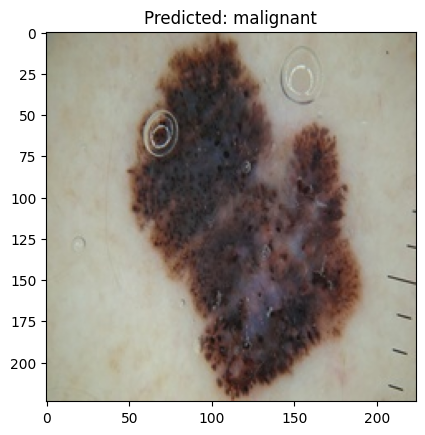

In [3]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
from torchvision import models

# تحميل النموذج
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
print(num_ftrs)

class_names=["benign","malignant"]
model.fc = nn.Linear(num_ftrs, len(class_names))

# GPU is availabel or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# load the weight of the model
model.load_state_dict(torch.load( r'path_to_save\Pytorch_trained_model1.pth'))


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# predict function
def predict_image(image_path, model, transform):
    model.eval()
    
    # load image and apply transformation
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # إضافة بُعد دفعة batch dimension
    
    # using GPU is available
    image = image.to(device)
    model = model.to(device)
    
    # predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item()

# load image
image_path = r'path of val data \3.jpg'
predicted_class = predict_image(image_path, model, transform)

# print the of class
print(f'The predicted class is: {class_names[predicted_class]}')

# show the image
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted: {class_names[predicted_class]}')
plt.show()


## GUI

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import filedialog
import os

# تحديد مسار النموذج المدرب
model_path = r'path_to_save\Pytorch_trained_model1.pth'

# load data
data_dir = r'path of data'
class_names = os.listdir(os.path.join(data_dir, 'train'))  # تأكد من أن لديك قائمة الفئات

# pretrained model ResNet18
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

print(num_ftrs)
model.fc = nn.Linear(num_ftrs, len(class_names))

# GPU is availabel or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# load the weight
model.load_state_dict(torch.load(model_path))

# apply the trainsformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_image(image_path, model, transform):
    model.eval()
    
    # load image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # إضافة بُعد دفعة batch dimension
    
    # using GPU if available
    image = image.to(device)
    model = model.to(device)
    
    # predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item()

def predict(path):
    # Predicts the model
    predicted_class = predict_image(path, model, transform)
    class_name = class_names[predicted_class]

    # Print prediction and confidence score
    print("Class:", class_name, end="")
    print(class_name)
    
    label = tk.Label(window, text=f"{class_name}         ", bg="white", fg="black", font=("Arial", 30))
    label.place(x=800, y=120)

def select():
    file = filedialog.askopenfile(mode="r", filetypes=[("Files", "*.jpg")])
    if file:
        file_path = os.path.abspath(file.name)
        predict(file.name)
        initial_image = Image.open(file_path)
        initial_photo = ImageTk.PhotoImage(image=initial_image)
        canvas.img = initial_photo
        canvas.create_image(760, 280, anchor=tk.NW, image=initial_photo)

# intial the window
window = tk.Tk()
canvas = tk.Canvas(window, width=1400, height=720, bg="white")
canvas.pack(fill="both", expand=True)

button = tk.Button(window, text="Select_Image", bg="red", command=select)
button.place(x=300, y=650, width=150, height=30)

initial_image = Image.open("cancer1.jpg")
initial_photo = ImageTk.PhotoImage(image=initial_image)
canvas.img = initial_photo
canvas.create_image(0, 0, anchor=tk.NW, image=initial_photo)

# loop to run Tkinter
window.mainloop()


C:\Users\fujtsu\anaconda3\envs\pythonProject1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fujtsu\anaconda3\envs\pythonProject1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
Class: benignbenign
Class: malignantmalignant


## Video DEMO

## https://www.linkedin.com/posts/abdelrahman-helal-3630a4259_abrskinabrcancerabrdetection-deeplearning-activity-7187018027865935874-Nt7-?utm_source=share&utm_medium=member_android